In [1]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


In [3]:
df = pd.read_csv("/kaggle/input/playground-series-s4e4/train.csv")

In [4]:
def drop_features(df, feature):
    df = df.drop([feature], axis=1, inplace=True)
    return df

In [5]:
drop_features(df, 'id')

In [6]:
class encoding(BaseEstimator, TransformerMixin):
    def __init__(self, column_1=['Sex']):
        self.column_1 = column_1
    def fit(self, df):
        return self
    def transform(self, df):
        oe = OrdinalEncoder()
        df[self.column_1] = oe.fit_transform(df[self.column_1])
        return df

In [7]:
class feature_scaling(BaseEstimator, TransformerMixin):
    def __init__(self, column_3=['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']):
        self.column_3 = column_3
    def fit(self, df):
        return self
    def transform(self, df):
        if (set(self.column_3).issubset(df.columns)):
            stc = Normalizer()
            df[self.column_3] = stc.fit_transform(df[self.column_3])
            return df
        else:
            print("Error")
            return df

In [8]:
pipe = Pipeline([
    ('encoding', encoding()),
    ('scaler', feature_scaling()),
])

In [9]:
pipe.fit_transform(df)

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0.0,0.483857,0.378288,0.131961,0.678719,0.288994,0.128882,0.211138,11
1,0.0,0.413300,0.321456,0.095125,0.741316,0.300463,0.181393,0.209930,11
2,1.0,0.811960,0.558223,0.126869,0.106570,0.027911,0.015224,0.025374,6
3,2.0,0.458481,0.366014,0.115583,0.704674,0.289344,0.158349,0.192639,10
4,1.0,0.483393,0.370166,0.113227,0.681105,0.321827,0.139357,0.172018,9
...,...,...,...,...,...,...,...,...,...
90610,2.0,0.737586,0.517411,0.165131,0.348977,0.150820,0.081465,0.099079,6
90611,2.0,0.449615,0.344300,0.121518,0.712093,0.313110,0.147036,0.194428,9
90612,1.0,0.651275,0.494071,0.142233,0.481345,0.226075,0.117529,0.122021,6
90613,1.0,0.683933,0.535252,0.148681,0.396483,0.194277,0.097138,0.138769,6


In [10]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [11]:
catboost_params = {
    'depth': 15,
    'max_bin': 464, 
    'verbose': False,
    'min_data_in_leaf': 78, 
    'loss_function': 'RMSE', 
    'grow_policy': 'Lossguide', 
    'bootstrap_type': 'Bernoulli', 
    'subsample': 0.83862137638162, 
    'l2_leaf_reg': 8.365422739510098, 
    'random_strength': 3.296124856352495, 
    'learning_rate': 0.09992185242598203, 
}

In [14]:
models = {
    'lda': LinearDiscriminantAnalysis(),
    'Random_Forest': RandomForestRegressor(n_estimators=150),
    'Ada_boost': AdaBoostRegressor(n_estimators=150),
    'Gradient_boost': GradientBoostingRegressor(n_estimators=150,learning_rate=1e-3),
    'Bagging_Classifer': BaggingRegressor(n_estimators=200, max_features=0.5, max_samples=1.0),
    'Decision_tree': DecisionTreeRegressor(),
    'Extr_tree': ExtraTreesRegressor(n_estimators = 200),
    'Catboost': CatBoostRegressor(**catboost_params)
}

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [19]:
def train_model(model, model_name, x=x_train, y=y_train, x_test = x_test, y_test = y_test):
    print("------------------------------", model_name , "------------------------------------------")
    model = model.fit(x, y)
    y_pred = model.predict(x_test)
    r2_score_train = r2_score(model.predict(x_train), y_train)
    r2_score_test = r2_score(y_pred, y_test)
    print("train")
    print("Mean score", ":", mean_squared_error(y_pred, y_test))
    print("Mean SQRT score", ":", np.sqrt(mean_squared_error(y_pred, y_test)))
    print("MSLE", ":", mean_squared_log_error(y_pred, y_test))
    print("RMSLE", ":", np.sqrt(mean_squared_log_error(y_pred, y_test)))
    #os.makedirs("/kaggle/input/playground-series-s4e4/artifacts",exist_ok=True)
    #with open(f'/kaggle/input/playground-series-s4e4/artifacts/{model_name}.pkl','wb') as f:
        #pickle.dump(model,f)

In [20]:
for model_name, model in models.items():
    train_model(model, model_name)

------------------------------ lda ------------------------------------------
train
Mean score : 4.782927771340286
Mean SQRT score : 2.186990574131559
MSLE : 0.030867653763712487
RMSLE : 0.17569192856734336
------------------------------ Random_Forest ------------------------------------------
train
Mean score : 3.753088375115722
Mean SQRT score : 1.937288924016168
MSLE : 0.025101961318159168
RMSLE : 0.15843598492185784
------------------------------ Ada_boost ------------------------------------------
train
Mean score : 6.098103854280452
Mean SQRT score : 2.4694339137301187
MSLE : 0.045284613557518796
RMSLE : 0.21280181756159602
------------------------------ Gradient_boost ------------------------------------------
train
Mean score : 8.824521711587074
Mean SQRT score : 2.9706096531835136
MSLE : 0.07174392911196575
RMSLE : 0.26785057235698745
------------------------------ Bagging_Classifer ------------------------------------------
train
Mean score : 3.8441691254233947
Mean SQRT scor

In [12]:
import torch
from torch import nn

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
class TrainTestSplit:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def NumpyToTensor(self) -> tuple[torch.Tensor, torch.Tensor]:
        x = torch.from_numpy(self.x.values).type(torch.float)
        y = torch.from_numpy(self.y.values).type(torch.float)
        return x, y
        
    def SplitData(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        x_tensor, y_tensor = self.NumpyToTensor()
        x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.8)
        return x_train, x_test, y_train, y_test

In [15]:
data_1 = TrainTestSplit(x, y)
x_train, x_test, y_train, y_test = data_1.SplitData()

In [16]:
class ModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=8, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=32)
        self.layer_4 = nn.Linear(in_features=32, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        a = self.layer_1(x)
        a = self.layer_2(a)
        a = self.layer_3(a)
        a = self.layer_4(a)
        return a

In [17]:
class TrainModelV2:
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs=200, lr=0.01):
        self.epochs = epochs
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.train_loss = list()
        self.test_loss = list()
        self.epoch_count = list()
        self.loss_fn = nn.L1Loss()
        self.optimizer = torch.optim.Adam(params=model_1.parameters(), lr=lr)
        
    def Plot(self):
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        plt.title("Train and Test loss Curves")
        plt.plot(self.epoch_count, self.train_loss, label="Training Loss")
        plt.plot(self.epoch_count, self.test_loss, label="Testing Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

    def Train(self):
        torch.manual_seed(42)
        for epoch in range(1, self.epochs + 1):
            self.model.train()
            y_pred = self.model(self.x_train)
            # Ensure target tensor has the same shape as y_pred
            target = self.y_train.view_as(y_pred)
            loss = self.loss_fn(y_pred, target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % 50 == 0:
                self.model.eval()
                with torch.inference_mode():
                    self.epoch_count.append(epoch)
                    test_pred = self.model(self.x_test)
                    # Ensure target tensor for test loss has the same shape as test_pred
                    target_test = self.y_test.view_as(test_pred)
                    test_loss = self.loss_fn(test_pred, target_test)
                    self.train_loss.append(loss.item())
                    self.test_loss.append(test_loss.item())
                    print(f"EpocH: {epoch} | loss: {loss.item()} | test_loss: {test_loss.item()}")

In [18]:
model_1 = ModelV1().to(device)

In [19]:
x_train_device = torch.tensor(x_train, dtype=torch.float, device=device)
y_train_device = torch.tensor(y_train, dtype=torch.long, device=device)
x_test_device = torch.tensor(x_test, dtype=torch.float, device=device)
y_test_device = torch.tensor(y_test, dtype=torch.long, device=device)

train_1 = TrainModelV2(model=model_1, x_train=x_train_device, y_train=y_train_device, x_test=x_test_device, y_test=y_test_device, epochs=2500, lr=1e-3)

/tmp/ipykernel_34/1706661466.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_device = torch.tensor(x_train, dtype=torch.float, device=device)
/tmp/ipykernel_34/1706661466.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_device = torch.tensor(y_train, dtype=torch.long, device=device)
/tmp/ipykernel_34/1706661466.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_device = torch.tensor(x_test, dtype=torch.float, device=device)
/tmp/ipykernel_34/1706661466.py:4: UserWarning: To copy construct from a tensor, it i

In [20]:
train_1.Train()

EpocH: 50 | loss: 2.9628586769104004 | test_loss: 2.8728983402252197
EpocH: 100 | loss: 1.9749926328659058 | test_loss: 1.9631743431091309
EpocH: 150 | loss: 1.63193678855896 | test_loss: 1.623815894126892
EpocH: 200 | loss: 1.5673881769180298 | test_loss: 1.5629559755325317
EpocH: 250 | loss: 1.5490281581878662 | test_loss: 1.5447617769241333
EpocH: 300 | loss: 1.527725338935852 | test_loss: 1.5234575271606445
EpocH: 350 | loss: 1.5019415616989136 | test_loss: 1.49760103225708
EpocH: 400 | loss: 1.4701858758926392 | test_loss: 1.465402364730835
EpocH: 450 | loss: 1.4322924613952637 | test_loss: 1.426440715789795
EpocH: 500 | loss: 1.393317699432373 | test_loss: 1.3860242366790771
EpocH: 550 | loss: 1.3678264617919922 | test_loss: 1.3587067127227783
EpocH: 600 | loss: 1.3585044145584106 | test_loss: 1.3482588529586792
EpocH: 650 | loss: 1.3553999662399292 | test_loss: 1.3446611166000366
EpocH: 700 | loss: 1.3536832332611084 | test_loss: 1.3428725004196167
EpocH: 750 | loss: 1.352573394

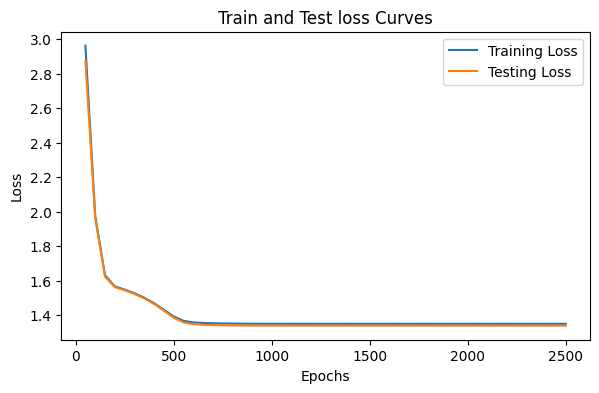

In [21]:
train_1.Plot()

In [22]:
test_df = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")

In [23]:
x1 = test_df.iloc[:, :]

In [24]:
test_df_1 = test_df[['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight']]

In [25]:
test_df_1

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050
...,...,...,...,...,...,...,...,...
60406,I,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500
60407,F,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050
60408,I,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650
60409,F,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350


In [26]:
pipe.fit_transform(test_df_1)

/tmp/ipykernel_34/2911537069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.column_1] = oe.fit_transform(df[self.column_1])
/tmp/ipykernel_34/806164321.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.column_3] = stc.fit_transform(df[self.column_3])


,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,2.0,0.387626,0.285461,0.093150,0.744001,0.371700,0.187803,0.180591
1,2.0,0.421592,0.334366,0.116301,0.714525,0.347813,0.159551,0.199893
2,2.0,0.468214,0.351161,0.117054,0.701903,0.294724,0.154260,0.201081
3,2.0,0.455757,0.391791,0.115938,0.698828,0.281850,0.149121,0.187900
4,1.0,0.612928,0.480004,0.162463,0.528743,0.232617,0.098955,0.155078
...,...,...,...,...,...,...,...,...
60406,1.0,0.713260,0.537529,0.175731,0.366967,0.151955,0.054787,0.103371
60407,0.0,0.443900,0.346665,0.122601,0.714045,0.328486,0.141202,0.173332
60408,1.0,0.408182,0.304407,0.107234,0.776237,0.271890,0.138367,0.183336
60409,0.0,0.345876,0.275128,0.099570,0.782674,0.308406,0.187349,0.227963


In [27]:
data = test_df_1.values

In [28]:
data

array([[2.        , 0.38762567, 0.28546076, ..., 0.37169996, 0.18780313,
        0.18059149],
       [2.        , 0.42159174, 0.33436586, ..., 0.34781319, 0.15955067,
        0.19989264],
       [2.        , 0.46821417, 0.35116063, ..., 0.2947241 , 0.15425985,
        0.20108126],
       ...,
       [1.        , 0.40818156, 0.30440658, ..., 0.27189043, 0.13836663,
        0.18333578],
       [0.        , 0.34587553, 0.27512826, ..., 0.30840568, 0.18734924,
        0.22796342],
       [0.        , 0.59241212, 0.46841888, ..., 0.21009965, 0.12537094,
        0.12468209]])

In [29]:
x = torch.from_numpy(test_df_1.values).type(torch.float64)

In [30]:
x[0]

tensor([2.0000, 0.3876, 0.2855, 0.0932, 0.7440, 0.3717, 0.1878, 0.1806],
       dtype=torch.float64)

In [31]:
torch.save(model_1, 'model.pth')

In [32]:
model = torch.load('model.pth')

In [33]:
predictions = []
for i in range(len(test_df_1)):
    input_tensor = x[i].float()  # Cast input tensor to float32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)
    input_tensor = input_tensor.view(1, -1) 
    model_1.to(device)
    with torch.no_grad():
        prediction = model_1(input_tensor)
        
    predictions.append(abs(round(prediction.item(), 0)))

In [34]:
data1 = pd.DataFrame(predictions, columns=['Rings'])

In [35]:
submission = pd.concat([test_df['id'], data1['Rings']], axis=1)

In [37]:
submission['Rings'].unique()

array([ 9., 10.,  8., 12.,  6., 11.,  7.,  5., 13.,  4., 16., 14., 15.,
       17.,  3., 18., 23.,  0.,  1., 24., 22., 25.])

In [38]:
submission

,id,Rings
0,90615,9.0
1,90616,10.0
2,90617,10.0
3,90618,10.0
4,90619,8.0
...,...,...
60406,151021,6.0
60407,151022,9.0
60408,151023,11.0
60409,151024,12.0


In [39]:
submission.to_csv("/kaggle/working/submission.csv", index=False)

In [41]:
!kaggle competitions  submit -c playground-series-s4e4 -f /kaggle/working/submission.csv

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
